In [1]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

## Prepare data

In [2]:
train_labels = keras_ocr.datasets.get_custom_dataset(split='train', path='/Users/evgenijastafurov/Desktop/2021/OCR_PYTHON.nosync/DigitsBracketsDataset')
test_labels = keras_ocr.datasets.get_custom_dataset(split='test', path='/Users/evgenijastafurov/Desktop/2021/OCR_PYTHON.nosync/DigitsBracketsDataset')

train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in test_labels]

## Extract recognizer from pipeline

Use commented lines if you want to provide special alphabet for model.
But keep in mind that you will change model architecture, hence training will be from scratch

In [3]:
# alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)

recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

2022-01-05 16:13:31.371583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Looking for /Users/evgenijastafurov/.keras-ocr/crnn_kurapan.h5


## Prepare batch  data  generator

In [4]:
batch_size = 8
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=alphabet
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, None), (validation_labels, None)]
]

training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

## Some sanity checks for data

text: 8307488


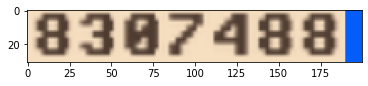

In [5]:
image, text = next(training_image_gen)
print('text:', text)
plt.imshow(image)

## Train the model

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1,
)

/tmp/ipykernel_11288/2768588646.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  recognizer.training_model.fit_generator(
55/55 [==============================] - 96s 2s/step - loss: 4.1334 - val_loss: 1.1628
/Users/evgenijastafurov/Desktop/2021/OCR_PYTHON.nosync/keras_ocr/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Check the result on the synthetic test data

Predicted: 4887954, Actual: 4887954
result: True


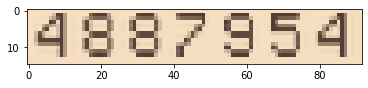

In [7]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
print('result: {}'.format(predicted == actual))
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

## Check the result on real data

Looking for /Users/evgenijastafurov/.keras-ocr/craft_mlt_25k.h5


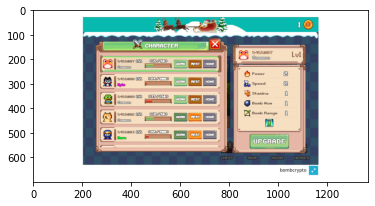

In [38]:
import cv2

img = cv2.imread('./tests/1.png') # real screenshot
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_ = plt.imshow(img)

#### Lets create pipline with our custom recognizer

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline(detector=keras_ocr.detection.Detector(), recognizer=recognizer)

#### Expand dims of the image, to create batch with single element

In [ ]:
prediction_groups = pipeline.recognize([img])

#### Plot the predictions

<AxesSubplot:>

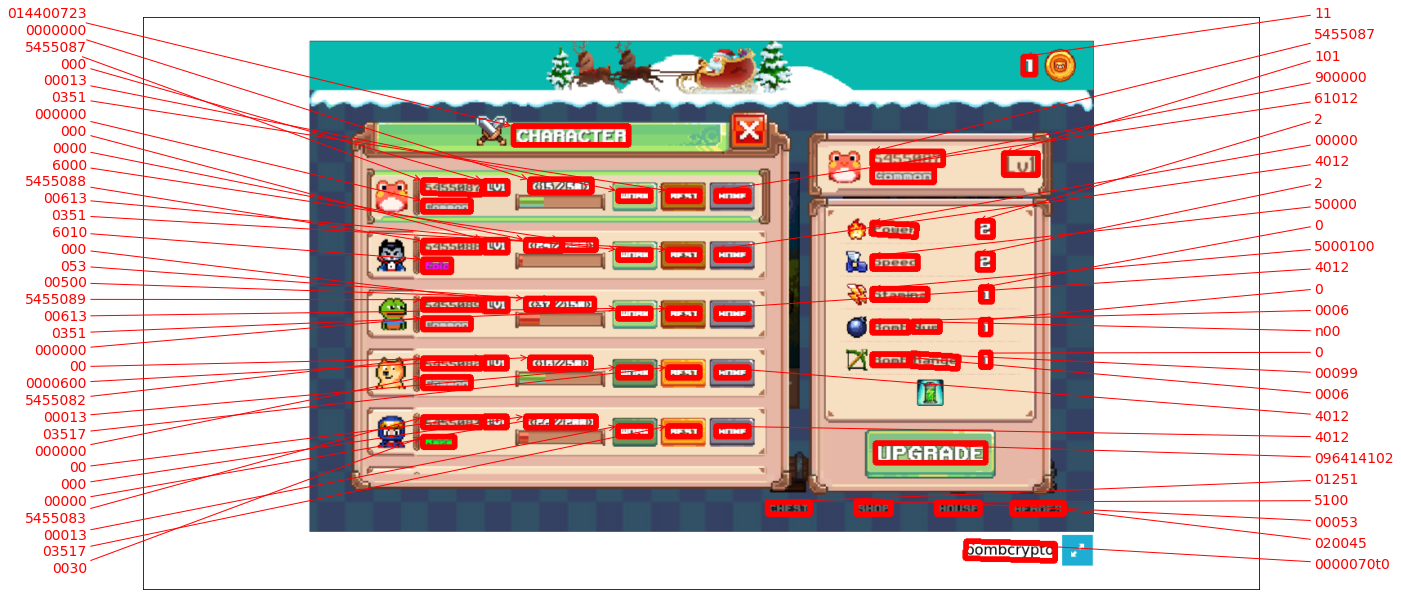

In [39]:
fig, ax = plt.subplots(nrows=1, figsize=(20, 20))
keras_ocr.tools.drawAnnotations(image=img, predictions=prediction_groups[0], ax=ax)

# Saving weights

In [14]:
recognizer.model.save_weights(filepath='./weights/fine_tune_loss4_small_font.h5')

#### See layers of recognizer

In [34]:
recognizer.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 permute (Permute)              (None, 200, 31, 1)   0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 200, 31, 1)   0           ['permute[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (None, 200, 31, 64)  640         ['lambda[0][0]']           